##Install libraries

The first step in this project involved installing all necessary libraries. Key dependencies include wandb for experiment tracking, tensorflow for model development, and torchvision for data preprocessing. These libraries were chosen for their robust functionality and seamless integration with popular machine learning ecosystems. Leveraging these tools accelerated development and evaluation processes. However, dependency management relies on an updated environment and stable internet connectivity to avoid compatibility issues.

In [ ]:
!pip install wandb datasets requests transformers torchvision huggingface_hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [31]:
import requests
import zipfile
import io
import wandb
import os
import numpy as np
import seaborn as sns
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

##Iniciate wandb

In [3]:
wandb.login()
wandb.init(project="trash-classification")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: stefaron-budhi (stefaron-budhi-universitas-kristen-duta-wacana). Use `wandb login --relogin` to force relogin


##Iniciate Dataset

The dataset used in this project was sourced from TrashNet, hosted on Hugging Face. This dataset contains images categorized by waste types. After downloading, a detailed analysis was conducted to ensure that all images were consistent in dimensions and ready for preprocessing. This initial step is crucial to ensure that the data pipeline runs smoothly, and it helps identify potential issues, such as non-standard image sizes, which could hinder model training.

In [ ]:
url = "https://huggingface.co/datasets/garythung/trashnet/resolve/main/dataset-resized.zip"

response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall("/content")


##Analyze dataset

To verify dataset quality, sample images from each category were visualized. This step provided insights into the visual variations across different classes and helped identify potential issues like mislabeled or noisy images. Understanding these characteristics guided the design of relevant data augmentation strategies to enhance model performance. While effective, this step does not automatically detect outliers or imbalanced distributions, necessitating further in-depth analysis.

In [6]:
data_dir = '/content/dataset-resized'

garbage_types = os.listdir(data_dir)

all_dimension_set = set()

for garbage_type in garbage_types:
  folder_path = os.path.join(data_dir, garbage_type)

  if os.path.isdir(folder_path):
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    num_images = len(image_files)
    print(f"Folder: {garbage_type}, Number of Images: {num_images}")

    for image_file in image_files:
      image_path = os.path.join(folder_path, image_file)
      with Image.open(image_path) as img:
        width, height = img.size
        channels = len(img.getbands())
        dimension = (width, height, channels)
        all_dimension_set.add(dimension)

if len(all_dimension_set) == 1:
  width, height, channels = all_dimension_set.pop()
  print(f"\nAll images have the same dimensions: {width} x {height} and {channels} color channels.")
else:
  print("\nImages have different dimensions or color channels.")

Folder: glass, Number of Images: 501
Folder: cardboard, Number of Images: 403
Folder: metal, Number of Images: 410
Folder: trash, Number of Images: 137
Folder: paper, Number of Images: 594
Folder: plastic, Number of Images: 482

All images have the same dimensions: 512 x 384 and 3 color channels.


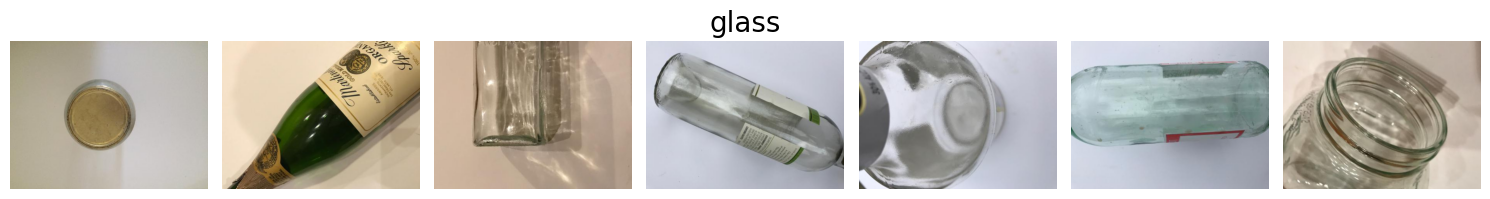

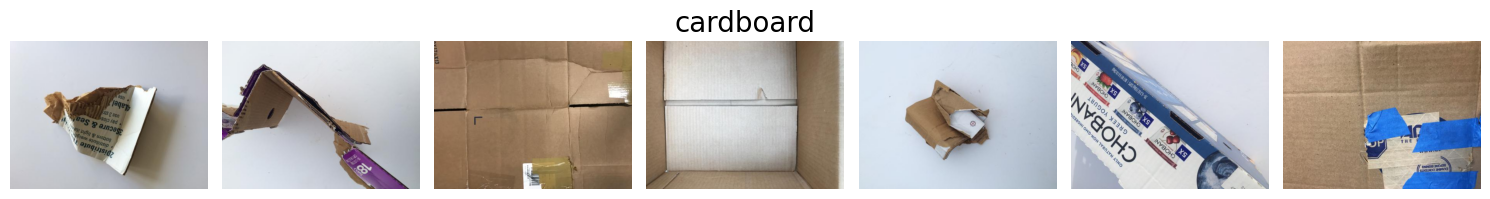

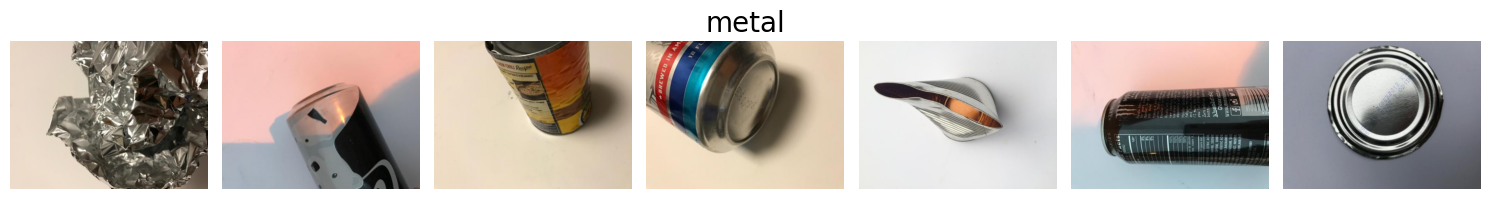

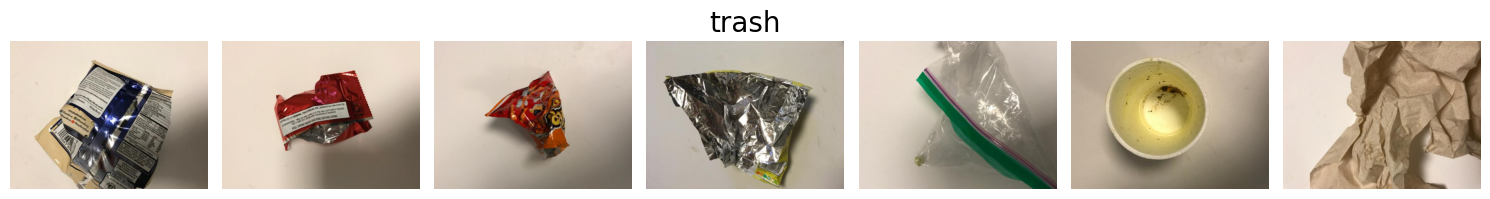

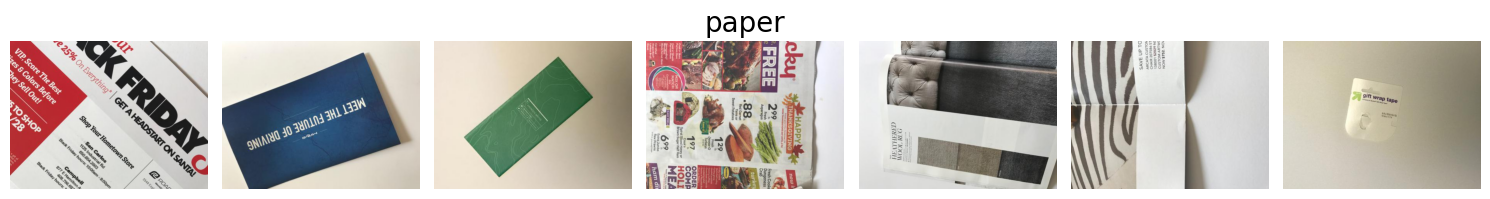

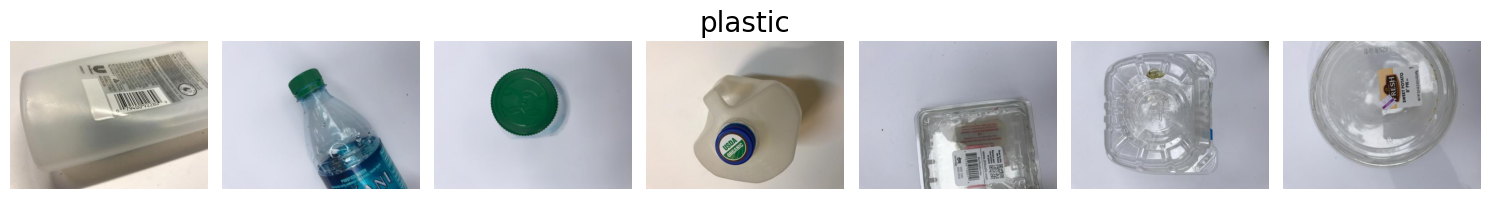

In [ ]:
for garbage_type in garbage_types:
    folder_path = os.path.join(data_dir, garbage_type)

    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        image_files = image_files[:7]

        fig, axs = plt.subplots(1, 7, figsize=(15, 2))

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')

        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)
        plt.show()

##Preprocessing data

The dataset was split into training and validation sets using stratified sampling to preserve class proportions. Data augmentation techniques, such as rotation, zooming, and flipping, were applied to improve the model’s generalization capabilities when faced with real-world variations. Additionally, preprocessing steps like normalization were implemented to expedite model convergence. While augmentation strengthens model robustness, improper parameter settings can introduce excessive noise, potentially degrading performance.

In [ ]:
data = []

for garbage_type in garbage_types:
    garbage_type_path = os.path.join(data_dir, garbage_type)
    if os.path.isdir(garbage_type_path):
        for file in os.listdir(garbage_type_path):
            data.append((os.path.join(garbage_type_path, file), garbage_type))

df = pd.DataFrame(data, columns=['filepath', 'label'])
df.head()

,filepath,label
0,/content/dataset-resized/glass/glass170.jpg,glass
1,/content/dataset-resized/glass/glass40.jpg,glass
2,/content/dataset-resized/glass/glass337.jpg,glass
3,/content/dataset-resized/glass/glass423.jpg,glass
4,/content/dataset-resized/glass/glass492.jpg,glass


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 2021
Number of images in the validation set: 506


In [ ]:
overall_distribution = df['label'].value_counts(normalize=True) * 100

train_distribution = train_df['label'].value_counts(normalize=True) * 100

val_distribution = val_df['label'].value_counts(normalize=True) * 100

print("Class distribution in the entire dataset:\n")
print(overall_distribution.round(2))
print('-'*40)

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))

Class distribution in the entire dataset:

label
paper        23.51
glass        19.83
plastic      19.07
metal        16.22
cardboard    15.95
trash         5.42
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
paper        23.50
glass        19.84
plastic      19.05
metal        16.23
cardboard    15.93
trash         5.44
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
paper        23.52
glass        19.76
plastic      19.17
metal        16.21
cardboard    16.01
trash         5.34
Name: proportion, dtype: float64


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=60,                 
    width_shift_range=0.15,             
    height_shift_range=0.15,        
    zoom_range=0.20,                 
    horizontal_flip=True,         
    vertical_flip=True,         
    shear_range=0.05,              
    brightness_range=[0.9, 1.1],     
    channel_shift_range=10,            
    fill_mode='nearest',              
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,       
    x_col="filepath",           
    y_col="label",                
    target_size=(384, 384),            
    batch_size=32,                  
    class_mode='categorical',  
    seed=42,                           
    shuffle=False                     
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                   
    x_col="filepath",                    
    y_col="label",                
    target_size=(384, 384),            
    batch_size=32,                  
    class_mode='categorical',  
    seed=42,                             
    shuffle=False                        
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [13]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 16


##Dealing with imbalanced datasets

After looking at the amount of data for each class folder, it can be concluded that the dataset is not balanced and the trash class has much smaller data than other classes. Therefore I will use class weight to give more weight to classes that have small datasets. With this, the model will pay more attention to underrepresented classes.

In [14]:
class_labels = train_df['label'].unique()
class_labels

array(['trash', 'glass', 'paper', 'metal', 'plastic', 'cardboard'],
      dtype=object)

In [15]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [16]:
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])
weights

array([3.06212121, 0.83998337, 0.70912281, 1.02693089, 0.87489177,
       1.04606625])

In [17]:
class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

{0: 3.062121212121212,
 1: 0.8399833748960931,
 2: 0.7091228070175438,
 3: 1.026930894308943,
 4: 0.8748917748917749,
 5: 1.0460662525879918}

##Build model with Transfer Learning

The chosen architecture leveraged ResNet50, a pretrained model trained on the ImageNet dataset. ResNet50 is a variant of Residual Networks (ResNet) that is well-known for its ability to handle degradation problems in training very deep neural networks.

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 384, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [19]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 384, 384, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 390, 390, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 192, 192, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 192, 192, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 192, 192, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 194, 194, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 96, 96, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 96, 96, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 96, 96, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 96, 96, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 96, 96, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 96, 96, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 96, 96, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 96, 96, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 96, 96, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [20]:
len(base_model.layers)

175

In [21]:
for i, layer in enumerate(base_model.layers):
    if 140 <= i <= 150:
        print(i, layer.name)

140 conv4_block6_3_bn
141 conv4_block6_add
142 conv4_block6_out
143 conv5_block1_1_conv
144 conv5_block1_1_bn
145 conv5_block1_1_relu
146 conv5_block1_2_conv
147 conv5_block1_2_bn
148 conv5_block1_2_relu
149 conv5_block1_0_conv
150 conv5_block1_3_conv


Fitting the model to specific data to improve accuracy, reduce training time, and prevent overfitting by only training the top layers of the model. Fine tuning by freezing the initial layers up to 142 (block 1 - 4) allows the model to continue learning general features from the dataset and open block 5, namely layers 143-175, because this block learns more detailed features in the dataset, therefore it is necessary to update the weights so that they can adjust to the trashnet dataset.

In [ ]:
for layer in base_model.layers[:143]: 
    layer.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 384, 384, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 390, 390, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 192, 192, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 192, 192, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 192, 192, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 194, 194, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 96, 96, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 96, 96, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 96, 96, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 96, 96, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 96, 96, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 96, 96, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 96, 96, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 96, 96, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 96, 96, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 14,988,294 (57.18 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

##Define Callback and Training Model

The model was trained using the Adam optimizer, along with callbacks such as early stopping, learning rate reduction, and checkpointing the best-performing model based on validation loss. These callbacks prevent overfitting, ensure efficient resource usage, and preserve the most optimal version of the model. However, there is a risk that early stopping might terminate training prematurely before the model fully converges.

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",  
    monitor="val_loss",       
    mode="min",               
    save_best_only=True,      
    verbose=1                 
)


callbacks = [reduce_lr, early_stopping, model_checkpoint]


num_epochs = 50

In [ ]:
history = model.fit(train_generator,
                    epochs=num_epochs,
                    validation_data=val_generator,
                    class_weight=class_weights,
                    callbacks=callbacks)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/64 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4967 - loss: 1.4044
Epoch 1: val_loss improved from inf to 0.52450, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.5013 - loss: 1.3901 - val_accuracy: 0.8142 - val_loss: 0.5245 - learning_rate: 1.0000e-04
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8389 - loss: 0.4287
Epoch 2: val_loss improved from 0.52450 to 0.38277, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8393 - loss: 0.4276 - val_accuracy: 0.8814 - val_loss: 0.3828 - learning_rate: 1.0000e-04
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9258 - loss: 0.2146
Epoch 3: val_loss improved from 0.38277 to 0.28438, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9258 - loss: 0.2146 - val_accuracy: 0.9209 - val_loss: 0.2844 - learning_rate: 1.0000e-04
Epoch 4/50
63/64 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9394 - loss: 0.163

##Model Evaluation

Model performance was assessed using metrics such as accuracy and loss curves, along with a classification report and confusion matrix. This evaluation provided a detailed understanding of how well the model handled each waste category and identified any bias toward specific classes. Visualizations like confusion matrices highlighted areas for improvement. Interpreting these metrics requires expertise to fully assess the model’s strengths and areas for refinement.

In [ ]:
def plot_learning_curves(history, start_epoch=5):
    
    min_len = min(len(history.history[key]) for key in history.history)
    truncated_history = {key: history.history[key][:min_len] for key in history.history}
    df = pd.DataFrame(truncated_history)
    df = df.iloc[start_epoch-1:]
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')
    plt.figure(figsize=(15,6))

    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

In [ ]:
def evaluate_model_performance(model, val_generator, class_labels):

    true_labels = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())
    predictions = model.predict(val_generator, steps=len(val_generator))
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = val_generator.classes
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

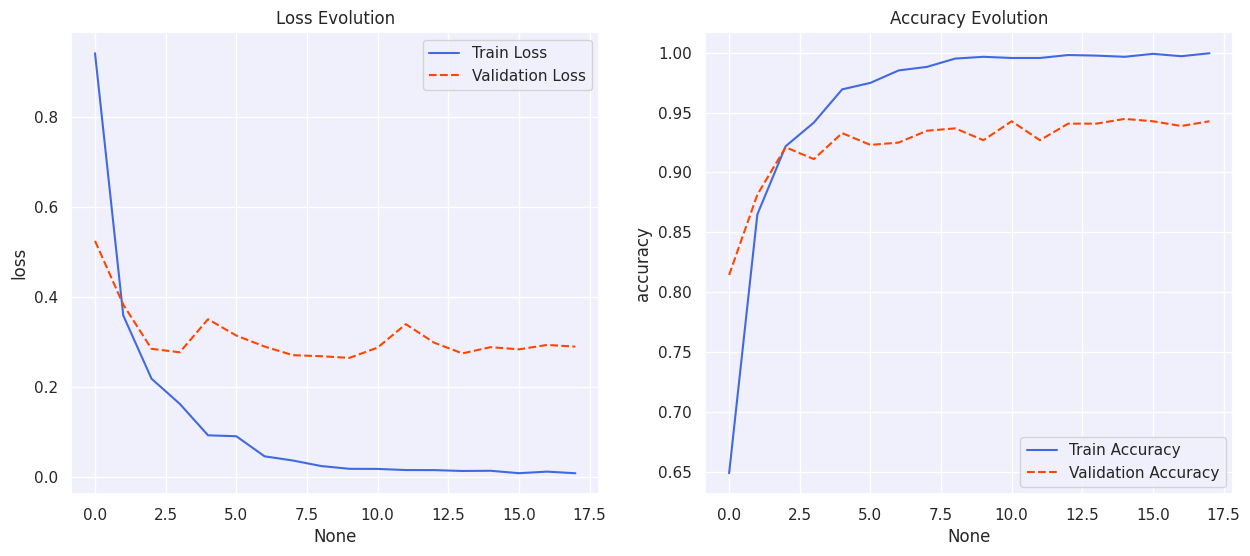

In [29]:
plot_learning_curves(history, start_epoch=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step
              precision    recall  f1-score   support

   cardboard       0.99      0.96      0.97        81
       glass       0.93      0.93      0.93       100
       metal       0.90      0.96      0.93        82
       paper       0.96      0.95      0.95       119
     plastic       0.96      0.89      0.92        97
       trash       0.65      0.74      0.69        27

    accuracy                           0.93       506
   macro avg       0.90      0.91      0.90       506
weighted avg       0.93      0.93      0.93       506





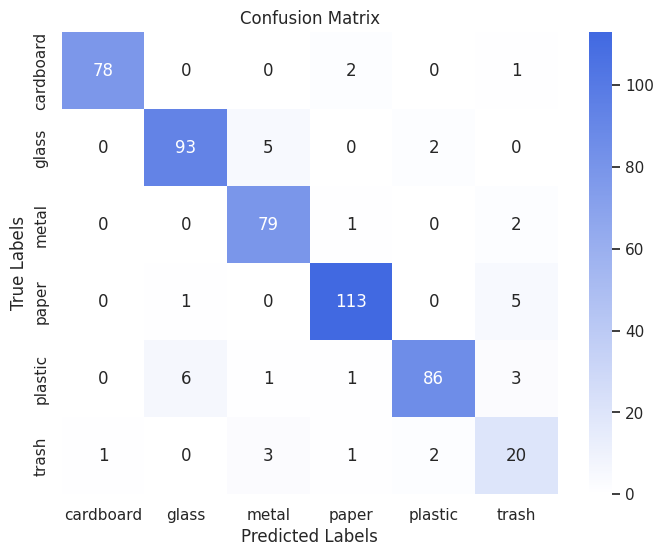

In [33]:
evaluate_model_performance(model, val_generator, class_labels)